In [1]:
# Import our libraries.

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from itertools import combinations
import seaborn as sns

import matplotlib.pyplot as plt

carolinaBlue = 'deepskyblue'  # because d00k sucks

In [2]:
folder = "2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/"

In [3]:
df = pd.read_csv("CreatedData/RegSeason_all.csv")

# Formatting

Per the Kaggle Competition (https://www.kaggle.com/c/mens-machine-learning-competition-2019)

Submission for the ML competition are submitted as a prediction using the following format.

The resulting submission format looks like the following, where "pred" represents the predicted probability that the first team will win
id,pred
2014_1107_1110,0.5
2014_1107_1112,0.5 
2014_1107_1113,0.5

yyyy_WTeamID_LTeamID, predicted_probability

# LogLoss Evaluation

https://www.kaggle.com/c/mens-machine-learning-competition-2019/overview/evaluation

Kaggle uses a LogLoss to evaluate the submissions.



In [4]:
# running logloss on a test set

test_label = [1,1,0,0,1,1,0,0]
test_predicted = [.5,.5,.5,.5,.5,.5,.5,.5]

log_loss(test_label, test_predicted, eps = 1e-15)

0.6931471805599453

ok, so we need to pass in an array of 1's and 0's based on whether we were right.
and then pass in our confidence.


# Creating a Baseline

I used the higher (better) seed winning every game with a confidence of 0.5 as my baseline. 

In [5]:
# Load Data.
Results = pd.read_csv(folder + "MNCAATourneyCompactResults.csv")
df_Seeds = pd.read_csv(folder + "MNCAATourneySeeds.csv")

In [6]:
# we need a quick and dirty function to convert Seed from its current format to an int.
 
def convertSeed(seed):
    '''Convert Seed from String to Int.
     so "W01" --> is 1, with the advent of the play in games, 
     we only care about 2nd and 3rd positions in the string.'''
    
    return (int(seed[1:3]))

In [7]:
# run conversion

df_Seeds['SeedInt'] = df_Seeds['Seed'].apply(convertSeed)

In [8]:
print(df_Seeds.head(2))
print(Results.head(2))

   Season Seed  TeamID  SeedInt
0    1985  W01    1207        1
1    1985  W02    1210        2
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0


We need to convert the seeds into an comparable integer and then merge the two databases together.


In [9]:
# split our two df's.  Rename once for winning seeds, once for losing seeds.
# every now and then I wish we had a nice vlookup in pandas.

winners = df_Seeds.rename(columns = {'TeamID':'WTeamID', 'SeedInt':'WSeed'}) 
df_merged = pd.merge(left = Results, right = winners, how = 'left', 
                    on=['Season', 'WTeamID' ])

losers = df_Seeds.rename(columns = {'TeamID':'LTeamID', 'SeedInt':'LSeed'}) 
df_merged = pd.merge(left = df_merged, right = losers, how = 'left', 
                    on=['Season', 'LTeamID' ])

# dropping more useless columns post merge

df_merged = df_merged.drop(columns=['Seed_x', 'Seed_y'])

In [10]:
# HWin is our target, 1 if lower(better) seed won
# we will use a 50% predicted probability as baseline

df_merged['Hwin'] = (df_merged['WSeed']<=df_merged['LSeed'])
df_merged['Pred_50'] = 0.50
df_merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,Hwin,Pred_50
0,1985,136,1116,63,1234,54,N,0,9,8,False,0.5
1,1985,136,1120,59,1345,58,N,0,11,6,False,0.5
2,1985,136,1207,68,1250,43,N,0,1,16,True,0.5
3,1985,136,1229,58,1425,55,N,0,9,8,False,0.5
4,1985,136,1242,49,1325,38,N,0,3,14,True,0.5


In [11]:
# lets see how that scores over last 10 years
for i in range(2010, 2020):
    score = df_merged[df_merged['Season']==i]
    print(str(i) + " : " + str(log_loss(score['Hwin'], score['Pred_50'], eps = 1e-15)))

2010 : 0.6931471805599453
2011 : 0.6931471805599454
2012 : 0.6931471805599454
2013 : 0.6931471805599454
2014 : 0.6931471805599454
2015 : 0.6931471805599454
2016 : 0.6931471805599454
2017 : 0.6931471805599454
2018 : 0.6931471805599454
2019 : 0.6931471805599454


In [12]:
pred_2019 = df_merged[df_merged['Season']==2019].drop(columns=['Season', 'DayNum', 'WTeamID', 
                                                               'WScore', 'LTeamID', 'LScore', 'WLoc',
                                                               'NumOT', 'WSeed', 'LSeed'])

In [13]:
# create inputs to chart LogLoss 

x = []
y = []
for i in np.arange(.05 , .95 , 0.025):
    pred_2019['Pred_50'] = i
    x.append(i)
    y.append(log_loss(pred_2019['Hwin'], pred_2019['Pred_50'], eps = 1e-15))

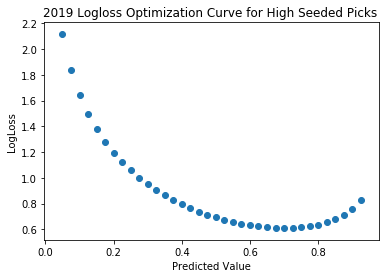

In [14]:
# can we optimize logloss?  Yup
plt.scatter(x, y)
plt.title('2019 Logloss Optimization Curve for High Seeded Picks ')
plt.ylabel('LogLoss')
plt.xlabel('Predicted Value')
plt.show()

# Predictions

Using Seed Differential
Using Per Game Stats

In [15]:
# basic stats - seed Differential

# we need to add columns for seed differential and absolute value of 
# seed diff so we can calculate the win % given the delta

df_merged['seed_diff'] = df_merged['WSeed'] - df_merged['LSeed']
df_merged['abs_seed_diff'] = abs(df_merged['seed_diff'])

df_merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,Hwin,Pred_50,seed_diff,abs_seed_diff
0,1985,136,1116,63,1234,54,N,0,9,8,False,0.5,1,1
1,1985,136,1120,59,1345,58,N,0,11,6,False,0.5,5,5
2,1985,136,1207,68,1250,43,N,0,1,16,True,0.5,-15,15
3,1985,136,1229,58,1425,55,N,0,9,8,False,0.5,1,1
4,1985,136,1242,49,1325,38,N,0,3,14,True,0.5,-11,11


In [16]:
# putting winrates into a table we can use later.

win_rates = []

for i in df_merged['abs_seed_diff'].unique():
    if i==0:
        win_rates.append([i, 0.5])
    else:
        win_rates.append([i, 1 - len(df_merged[df_merged['seed_diff'] == i])/len(df_merged[df_merged['abs_seed_diff'] == i])])

df_win = pd.DataFrame(win_rates,  columns=['abs_seed_diff', 'win_rate'])
df_win.head()

,abs_seed_diff,win_rate
0,1,0.539510
1,5,0.669388
2,15,0.992857
3,11,0.868750
4,7,0.694690


In [17]:
df_seedDiff = pd.merge(df_merged, df_win, on='abs_seed_diff')

In [18]:
# print results
print("Correct Winner Predicted %: " + str(df_seedDiff[df_seedDiff["Hwin"]==True].shape[0] / df_seedDiff["Hwin"].count()))



Correct Winner Predicted %: 0.7258996001776988


0.5465141109726465

In [19]:
# lets see how adding a seed diff confidence interval changes our scores over last 10 years

years = range(2010,2020)
score = []
score_seed = []
for i in range(2010, 2020):
    temp_df = df_seedDiff[df_seedDiff['Season']==i]
    score.append(log_loss(temp_df['Hwin'], temp_df['Pred_50'], eps = 1e-15))
    score_seed.append(log_loss(temp_df['Hwin'], temp_df['win_rate'], eps = 1e-15))


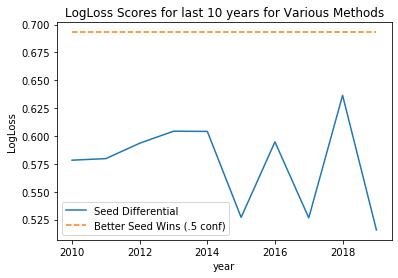

In [20]:
fig, ax = plt.subplots()
ax.plot(years, score_seed, label = "Seed Differential")
ax.plot(years, score, '--', label = "Better Seed Wins (.5 conf)")

plt.title('LogLoss Scores for last 10 years for Various Methods')
plt.ylabel('LogLoss')
plt.xlabel('year')
plt.legend(loc="best")
plt.show()

# Other Attempts to Create a Better Model?


In [21]:
#create output using season averages and classifier weights

In [22]:
# The static version to make sure my code is right

year = 2019
TeamID1 = 1181 #Duke
TeamID2 = 1277 #Michigan State

In [23]:
RegSeason_means = df.groupby(['TeamID','Season']).mean().reset_index()

In [24]:
team1 = RegSeason_means.loc[(RegSeason_means['Season']==year) & (RegSeason_means['TeamID']==TeamID1)]
team2 = RegSeason_means.loc[(RegSeason_means['Season']==year) & (RegSeason_means['TeamID']==TeamID2)]

In [25]:
# the same stats we used in our model.

stats = ['TO', 'Stl', 'Blk', 'PF', 'Possessions', 'Shooting_Eff', 'EffectiveFGP',
       'FGP3', 'Off_Rating', 'Def_Rating', 'Off_RBP', 'Def_RBP', 'Tot_RBP',
       'TO_Rate', 'Ast_Ratio', 'Blk_Ratio', 'Stl_Ratio']

# we need to reverse the output given by the model since it is in reverse of the feature order we have.

optimal_weights = [6.68927175e-03, 3.67280849e-03, 3.90166089e-03, 1.28102447e-02,
                   2.32361181e-03, 1.03558171e-01, 1.51972569e-02, 1.98526926e-02, 
                   3.02398840e-01, 4.34409879e-01, 7.62907790e-03, 4.29247169e-03, 
                   3.79232469e-02, 1.17047253e-02, 1.78004618e-02, 6.94073927e-03, 
                   8.87274445e-03]



In [32]:
# create function to parse file format into prediction labels.

def translate_prediction(single_prediction):
    '''
        Function takes in a single prediction line and returns a list with 2 values 
        with format [boolean prediction_is_correct, confidence]
        
    '''
    s, p = single_prediction
    year, team1, team2 = map(int, s.split('_'))
    temp_df = Results.loc[(Results['Season'] == year) & 
                      (((Results['WTeamID'] == team1) & (Results['LTeamID'] == team2)) |
                      ((Results['WTeamID'] == team2) & (Results['LTeamID'] == team1)))
                        ]
    try:
        if temp_df['WTeamID'].values[0] == team1:
            return ([1, p])
        else:
            return ([0, p])                

    except:
        #game doesn't happen
        pass

In [ ]:
# determine higher seed

def return_higher_seed(TeamID1, TeamID2, year):
    '''
    takes in 2 teams, and the season (year) in which they are being compared
    
    returns in string format (year_team1_team2) where team1 is the higher seeded team
    '''
    
    seed1 = df_Seeds.loc[(df_Seeds['Season']==year) & (df_Seeds['TeamID']==TeamID1)]['SeedInt'].values[0]
    seed2 = df_Seeds.loc[(df_Seeds['Season']==year) & (df_Seeds['TeamID']==TeamID2)]['SeedInt'].values[0]
    if seed1 >= seed2:
        return (str(year) + "_" + str(TeamID1) + "_" + str(TeamID2))
    else:
        return (str(year) + "_" + str(TeamID2) + "_" +  str(TeamID1))

In [33]:
def contrast_teams(TeamID1, TeamID2, year):
    '''
    takes in 2 teams, and the season (year) in which they are being compared
    
    Uses our optimal weights to predict both the winner and our confidence in that win.
    
    returns in string format (year_team1_team2) where team1 is the higher seeded team
    '''    
    
    # the same stats we used in our model.
    team1 = RegSeason_means.loc[(RegSeason_means['Season']==year) & (RegSeason_means['TeamID']==TeamID1)]
    team2 = RegSeason_means.loc[(RegSeason_means['Season']==year) & (RegSeason_means['TeamID']==TeamID2)]
    stats = ['TO', 'Stl', 'Blk', 'PF', 'Possessions', 'Shooting_Eff', 'EffectiveFGP',
             'FGP3', 'Off_Rating', 'Def_Rating', 'Off_RBP', 'Def_RBP', 'Tot_RBP',
             'TO_Rate', 'Ast_Ratio', 'Blk_Ratio', 'Stl_Ratio']
    optimal_weights = [6.68927175e-03, 3.67280849e-03, 3.90166089e-03, 1.28102447e-02,
                   2.32361181e-03, 1.03558171e-01, 1.51972569e-02, 1.98526926e-02, 
                   3.02398840e-01, 4.34409879e-01, 7.62907790e-03, 4.29247169e-03, 
                   3.79232469e-02, 1.17047253e-02, 1.78004618e-02, 6.94073927e-03, 
                   8.87274445e-03]

    team1_score = 0.0
    team2_score = 0.0
    for i in np.arange(0, len(stats)):
        team1_score = team1_score + int(team1[stats[i]] * optimal_weights[i])
        team2_score = team2_score + int(team2[stats[i]] * optimal_weights[i])

    if (team1_score > team2_score):
# how do we calculate our confidence
        return ([str(year) + "_" + str(TeamID1) + "_" + str(TeamID2),  
                 (team1_score*1.2 /  (team1_score + team2_score))])
    else:
        return ([str(year) + "_" + str(TeamID2) + "_" + str(TeamID1),  
                 (team2_score*1.2 /  (team1_score + team2_score))])
    


In [34]:
# create our team list for a static year.

teams_2019 = df_Seeds[df_Seeds['Season']==2019]['TeamID'].values
teams_2019

array([1181, 1277, 1261, 1439, 1280, 1268, 1257, 1433, 1416, 1278, 1125,
       1396, 1251, 1387, 1463, 1133, 1295, 1300, 1211, 1276, 1403, 1199,
       1266, 1138, 1305, 1393, 1124, 1196, 1113, 1385, 1293, 1436, 1297,
       1285, 1192, 1341, 1314, 1246, 1222, 1242, 1120, 1235, 1459, 1429,
       1449, 1371, 1326, 1308, 1318, 1209, 1101, 1233, 1438, 1397, 1345,
       1243, 1458, 1437, 1153, 1279, 1328, 1234, 1388, 1332, 1414, 1330,
       1159, 1205], dtype=int64)

In [35]:
# predict with model

def run_optimal_model(teams, year):
    '''
    takes in an array of teams that are participating in the tournament in the specified year.
    
    returns our prediction using the kaggle submission format with model calculated probability
    '''
    
    output = []
    comb = combinations(teams, 2)
    for i in list(comb):
        output.append(contrast_teams(i[0], i[1], year))
    return (output)


In [36]:
output_2019_actual = run_optimal_model(teams_2019, 2019)

# How did we do?

In [40]:

predictions = []
for i in output_2019_actual:
    x = translate_prediction(i)
    if x is not None:
        predictions.append(x)
df_win_actual = pd.DataFrame(predictions,  columns=['correct', 'confidence'])
df_win_actual.head()       
log_loss(df_seedDiff['Hwin'], df_seedDiff['win_rate'], eps = 1e-15)

0.5465141109726465